# Learning Model (SVD)
Now that we've implemented naive user-based CF, we'll implement a more advanced model - the SVD model.

INSERT DESCRIPTION HERE

One disadvantage of the SVD model is that it can't generalize to unseen items - predictions rely on item and user factors which are learned during model training. When training our model, 

In [1]:
%%capture
import sys
import os

# Add project root to Python path
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)
# import packages
from utils.imports import *
# import user-defined funcs and classes
from utils.helpers import plot_heatmap
from models.ManualSVD import ManualSVD

In [2]:
# import pandas dataframes
with open("../data/dataframes.pkl", "rb") as f:
    data = pickle.load(f)

train = data["train"]
validation = data["validation"]
baseline = data["baseline"]

# load sparse matrix
ui_csr = load_npz("../data/ui_csr.npz")

# load encodings
with open("../artifacts/user_encoder.pkl", "rb") as f:
    user_encoder = pickle.load(f)
with open("../artifacts/item_encoder.pkl", "rb") as f:
    item_encoder = pickle.load(f)
with open("../artifacts/user_map.pkl", "rb") as f:
    user_map = pickle.load(f)
with open("../artifacts/item_map.pkl", "rb") as f:
    item_map = pickle.load(f)

In [ ]:
%%capture
# this grid search takes a long time to run so it's quoted out

"""k_grid = np.array([25,50,75, 100]) # set k grid
reg_grid = np.array([0.001, 0.02, 0.1]) # set reg grid
grid = itertools.product(k_grid, reg_grid)
models = []
# dataframe for grid search
grid_search = pd.DataFrame(columns=('reg', 'k', 'RMSE', 'MAE', 'coverage', 'hit_rate'))
for k, reg in grid:
    # fit model with grid params
    model = ManualSVD(k=k, reg=reg)
    model.fit(ui_csr, validation, verbose=False)
    #evaluate
    N_1, N_2 = 100, 10
    hit_rate = model.hit_rate_at_N(validation, N_1) # get hit rate @ top 100 beers
    coverage = model.top_N_coverage(N_2) # get training set item catalog coverage @ top 10 beers
    # add results to dataframe
    grid_search.loc[len(grid_search)]= (reg, k, model.RMSE_clipped, model.MAE, coverage, hit_rate)
    # save model
    models.append(model)
    print('\n')"""

In [13]:
# load results of grid search
with open("../artifacts/models.pkl", "rb") as f:
    models = pickle.load(f)
with open("../data/grid_search.pkl", "rb") as f:
    grid_search = pickle.load(f)

In [14]:
grid_search

,reg,k,RMSE,MAE,coverage,hit_rate
0,0.001,25.0,0.709072,0.503008,0.3538,0.011962
1,0.020,25.0,0.708975,0.503146,0.4916,0.004218
2,0.100,25.0,0.709109,0.504633,0.4477,0.001106
3,0.001,50.0,0.714839,0.508159,0.6420,0.007952
4,0.020,50.0,0.712586,0.506085,0.7154,0.002904
5,0.100,50.0,0.711421,0.505739,0.6117,0.000968
6,0.001,75.0,0.719106,0.511409,0.7800,0.006707
7,0.020,75.0,0.713144,0.506915,0.7949,0.002628
8,0.100,75.0,0.711676,0.506189,0.6626,0.000622
9,0.001,100.0,0.719070,0.513380,0.8407,0.006500


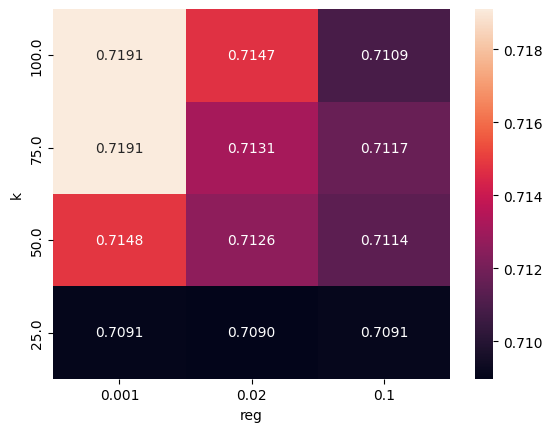

In [15]:
# plot RMSE values
# these values are the clipped prediction RMSE values, not the SGD learning values
plot_heatmap(grid_search, "RMSE")

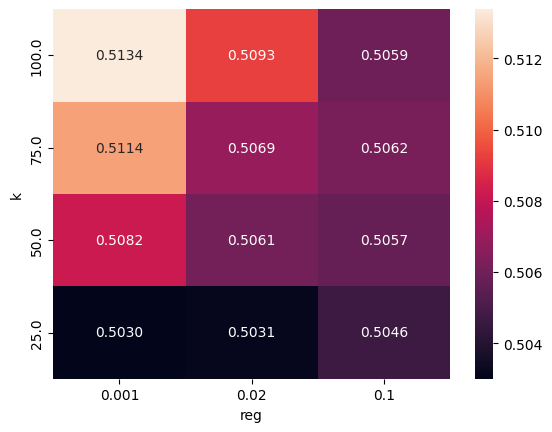

In [16]:
# plot RMSE values
# these values are the clipped prediction RMSE values, not the SGD learning values
plot_heatmap(grid_search, "MAE")

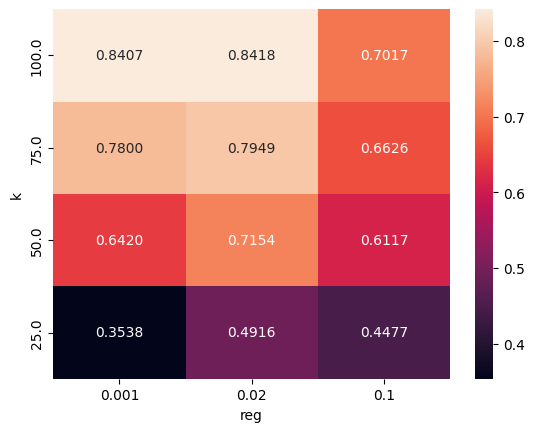

In [17]:
# plot coverage values
plot_heatmap(grid_search, "coverage")

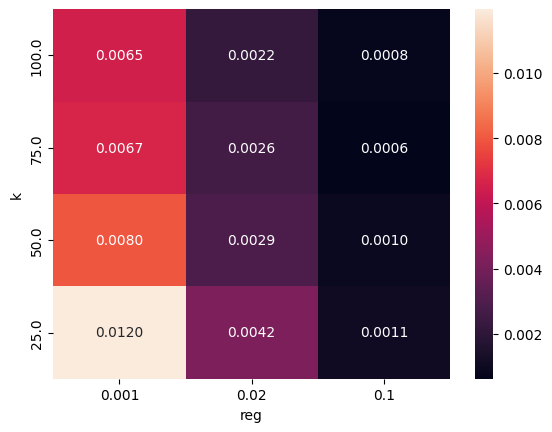

In [18]:
# plot hit-rate values
plot_heatmap(grid_search, "hit_rate")